## Yolo v1

### Yolo v1 Architecture

- Input: $(448, 448, 3)$
- Y True Labels: $(7, 7, 30)$
- Y Pred Labels: $(7, 7, 30)$

where the image is divided into $7 \times 7$ grid. Each grid cell is therefore of $448 / 7 = 64$ pixel of size.

- Then after many layers we need to connect it to a stack of feature maps of $7 \times 7 \times 30$ where each channel of shape $(30, )$ is encoded
by the below diagram: `(objectness, x, y, w, h, ......, p1, p2, ..., p20)`.
- Each grid cell can predict 2 bounding boxes but only 1 with the highest IOU with the ground truth will be chosen.

### Loss

\begin{align}
&\lambda_{coord} \sum_{i=0}^{S^2}\sum_{j=0}^B \mathbb{1}_{ij}^{obj}[(x_i-\hat{x}_i)^2 + (y_i-\hat{y}_i)^2 ] \\&+ \lambda_{coord} \sum_{i=0}^{S^2}\sum_{j=0}^B \mathbb{1}_{ij}^{obj}[(\sqrt{w_i}-\sqrt{\hat{w}_i})^2 +(\sqrt{h_i}-\sqrt{\hat{h}_i})^2 ]\\
&+ \sum_{i=0}^{S^2}\sum_{j=0}^B \mathbb{1}_{ij}^{obj}(C_i - \hat{C}_i)^2 + \lambda_{noobj}\sum_{i=0}^{S^2}\sum_{j=0}^B \mathbb{1}_{ij}^{noobj}(C_i - \hat{C}_i)^2 \\
&+ \sum_{i=0}^{S^2} \mathbb{1}_{i}^{obj}\sum_{c \in classes}(p_i(c) - \hat{p}_i(c))^2 \\
\end{align}


Explanation of the different terms : 

- The 3 $\lambda$ constants are just constants to take into account more one aspect of the loss function. In the article $\lambda_{coord}$ is the highest in order to have the more importance in the first term
- The prediction of YOLO is a $S*S*(B*5+C)$ vector : $B$ bbox predictions for each grid cells and $C$ class prediction for each grid cell (where $C$ is the number of classes). The 5 bbox outputs of the box j of cell i are coordinates of tte center of the bbox $x_{ij}$ $y_{ij}$ , height $h_{ij}$, width $w_{ij}$ and a confidence index $C_{ij}$
- I imagine that the values with a hat are the real one read from the label and the one without hat are the predicted ones. So what is the real value from the label for the confidence score for each bbox $\hat{C}_{ij}$ ? It is the intersection over union of the predicted bounding box with the one from the label.
- $\mathbb{1}_{i}^{obj}$ is $1$ when there is an object in cell $i$ and $0$ elsewhere
- $\mathbb{1}_{ij}^{obj}$ "denotes that the $j$th bounding box predictor in cell $i$ is responsible for that prediction". In other words, it is equal to $1$ if there is an object in cell $i$ and confidence of the $j$th predictors of this cell is the highest among all the predictors of this cell. $\mathbb{1}_{ij}^{noobj}$ is almost the same except it values 1 when there are NO objects in cell $i$

Note that I used two indexes $i$ and $j$ for each bbox predictions, this is not the case in the article because there is always a factor $\mathbb{1}_{ij}^{obj}$ or $\mathbb{1}_{ij}^{noobj}$ so there is no ambigous interpretation : the $j$ chosen is the one corresponding to the highest confidence score in that cell.

**More general explanation of each term of the sum**:

1. this term penalize bad localization of center of cells
2. this term penalize the bounding box with inacurate height and width. The square root is present so that erors in small bounding boxes are more penalizing than errors in big bounding boxes.
3. this term tries to make the confidence score equal to the IOU between the object and the prediction when there is one object
4. Tries to make confidence score close to $0$ when there are no object in the cell
5. This is a simple classification loss (not explained in the article)

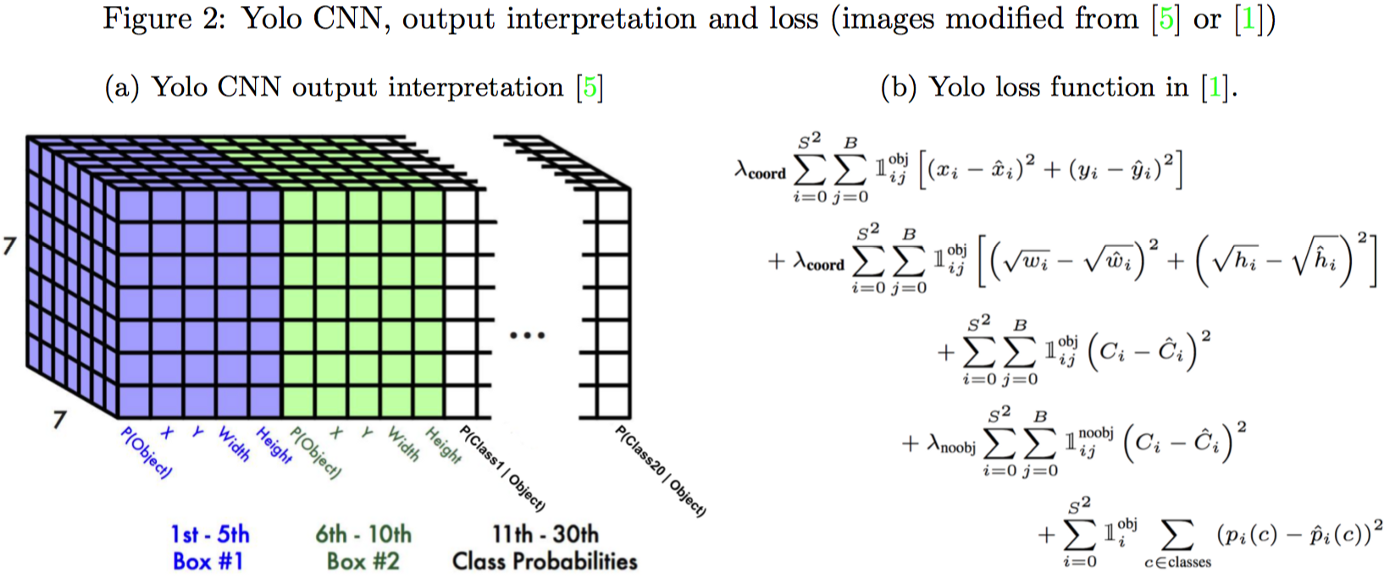

### Intuition

See diagram below of a human and dog. There should be 2 gt bbox but model not smart predicted 4 bboxes, 2 around human 2 around dog.

- Let's say bbox A has the highest confidence score amongst the 4. We pick A;
- We compare IOU of A with B, C and D and get say 0.9, 0 and 0.1 respectively.
- Set a threshold of $t = 0.5$ for example.
- We discard all bboxes with IOU more than $t$, which in this case B is discarded immediately. At this point you should realize that for the human object we really want 1 bbox only, so B being removed is a result of the algorithm detecting that B is too close to A and hence it is related to the human bbox.
- Next, we get the highest confidence score in C, D, let's say it is D. Here is a repeat of step 1 already.
- We compare IOU of D and C and find them to be 0.6, we discard it too. Now no more bbox left.
- We are left with A and D, as desired.


<img src="https://storage.googleapis.com/reighns/reighns_ml_projects/docs/projects/LTA/images/nms_image_vis.jpg" width="500" height="500" />